In [5]:
# taken from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

# Load data and prepare data-frame
# - strip unused columns 
# - add additional information
# - remove too short utterances

import pandas as pd
import sys
from os import path

sys.path.append(path.abspath('..'))
from webserver.classification import trainer
min_word_count = 2


data_path = '../webserver/model_data'
col = ['utterance', 'category']
categories_to_consider = ['praise', 'dissence', 'lecture', 'concession', 'insinuation']

df = trainer.load_training_files(data_path, ['Boris', 'Pelle'], categories_to_consider) # ['Boris', 'Pelle']

category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

df.head()

Loading /Users/staude/Projekte/BorisJoens/SmallData/webserver/model_data/TrainingDataPelle01.tsv
Loading /Users/staude/Projekte/BorisJoens/SmallData/webserver/model_data/TrainingDataBoris01.tsv


,utterance,category,word_count,category_id
0,Schöne ausführliche Zusammenfassung.,praise,3,0
1,Selten einen solchen Mist gelesen Herr Stöker !!!,dissence,8,1
2,Absolut Richtig!,praise,3,0
3,Ach kommen sie sie wissen schon das die meiste...,lecture,16,2
4,Sie treffen den Nagel auf den Kopf.,praise,7,0


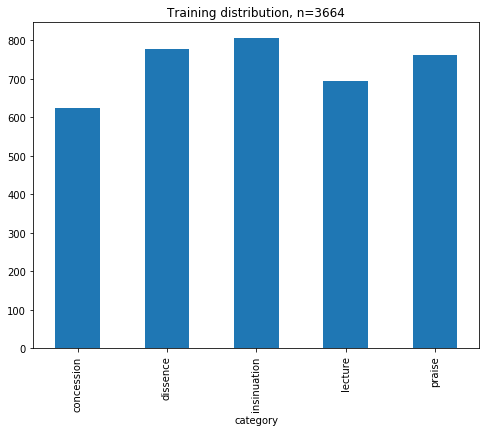

In [6]:
# Analyze category distribution

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').utterance.count().plot.bar(ylim=0)
plt.title('Training distribution, n={}'.format(len(df)))
plt.show()

In [7]:
# Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
import numpy as np

vectorizer_name = 'german_model'
def vectorize(df, vectorizer_name):
    if vectorizer_name == 'tfidf':
        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2))
        # , stop_words=get_stop_words('de'))
        features = tfidf.fit_transform(df.utterance).toarray()
    elif vectorizer_name == 'german_model':
        import sys, os
        sys.path.insert(0, os.path.abspath('..'))
        from webserver.classification import trainer
        sentences = df.utterance.to_list()
        categories = df.category_id.to_list()
        sentences_cleaned, features, labels = trainer.vectorize_corpus(sentences, trainer.sentence_to_vec_german_model, categories=categories)
        print('Removed {} sentences'.format(len(sentences)-len(sentences_cleaned)))
        df = pd.DataFrame(np.array([sentences_cleaned, [id_to_category[ll] for ll in labels]]).T, columns = ['utterance', 'category'])
        df['category_id'] = labels
    return df, features

df, features = vectorize(df, vectorizer_name)
features.shape

Vectorizing Corpus ...
Removed 20 sentences


(3644, 300)

In [5]:
# Analyze predictive features (works only for TFIDF)

from sklearn.feature_selection import chi2
import numpy as np
N = 2
features_chi2 = {}
feature_names = {}

for Effekt, category_id in sorted(category_to_id.items()):
  raw_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(raw_chi2[0])[::-1]
  feature_names[category_id] = np.array(tfidf.get_feature_names())[indices]
  features_chi2[category_id] = raw_chi2[0][indices]
  unigrams = [v for v in feature_names[category_id] if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names[category_id] if len(v.split(' ')) == 2]
  print("# '{}':".format(Effekt))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[0:N])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[0:N])))

# 'concession':
  . Most correlated unigrams:
. ich
. aber
  . Most correlated bigrams:
. sich diese
. ich mag
# 'dissence':
  . Most correlated unigrams:
. nein
. ernst
  . Most correlated bigrams:
. ich nicht
. was für
# 'insinuation':
  . Most correlated unigrams:
. merkel
. vermutlich
  . Most correlated bigrams:
. die meisten
. gleich wieder
# 'lecture':
  . Most correlated unigrams:
. sollte
. bitte
  . Most correlated bigrams:
. sie sich
. wer sich
# 'praise':
  . Most correlated unigrams:
. danke
. super
  . Most correlated bigrams:
. danke für
. vielen dank


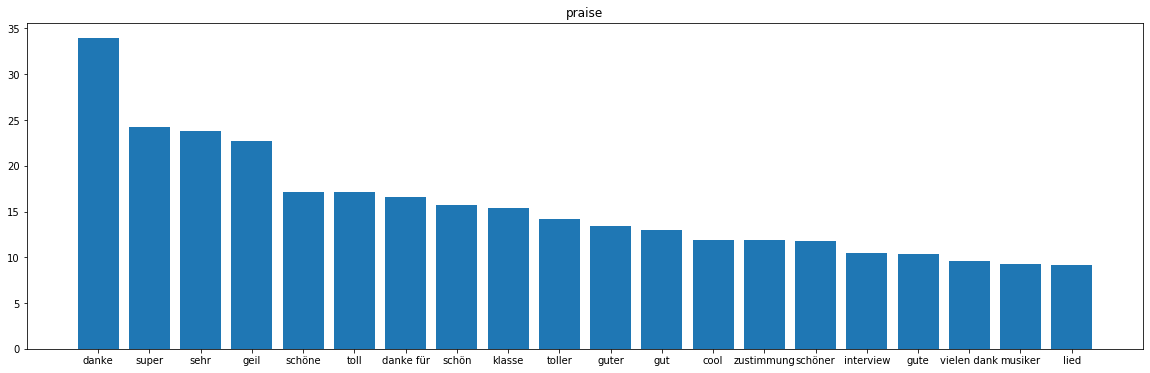

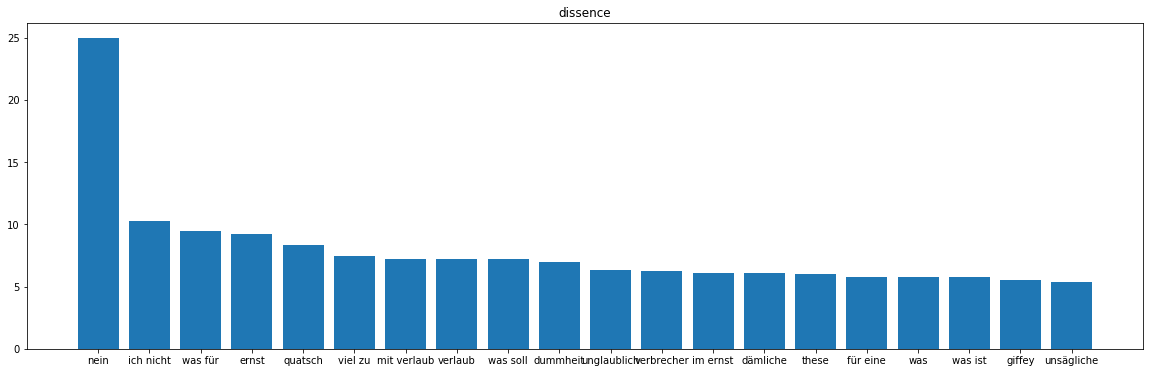

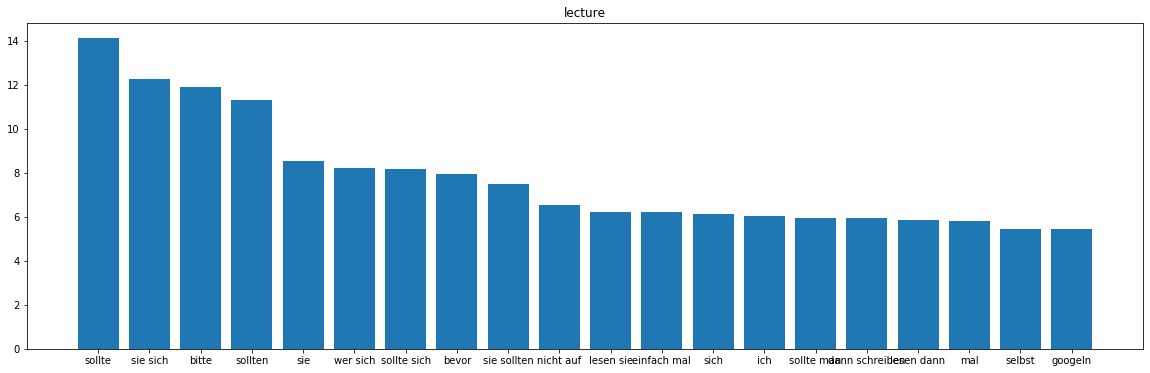

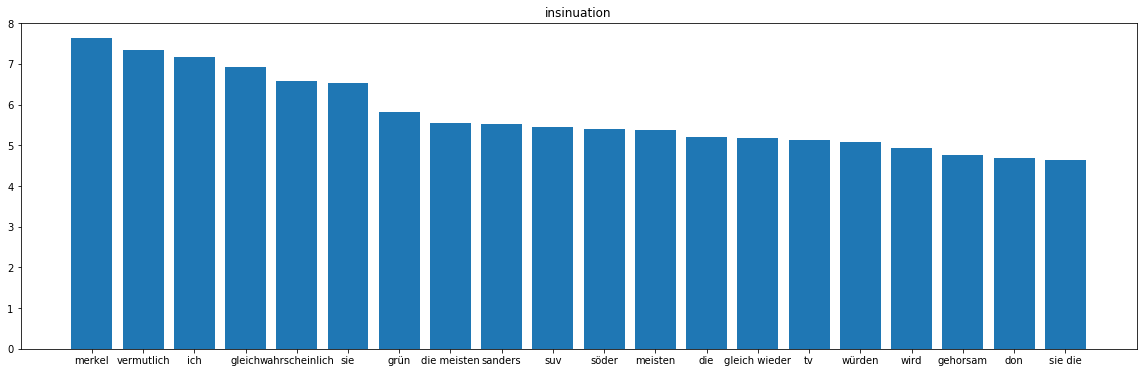

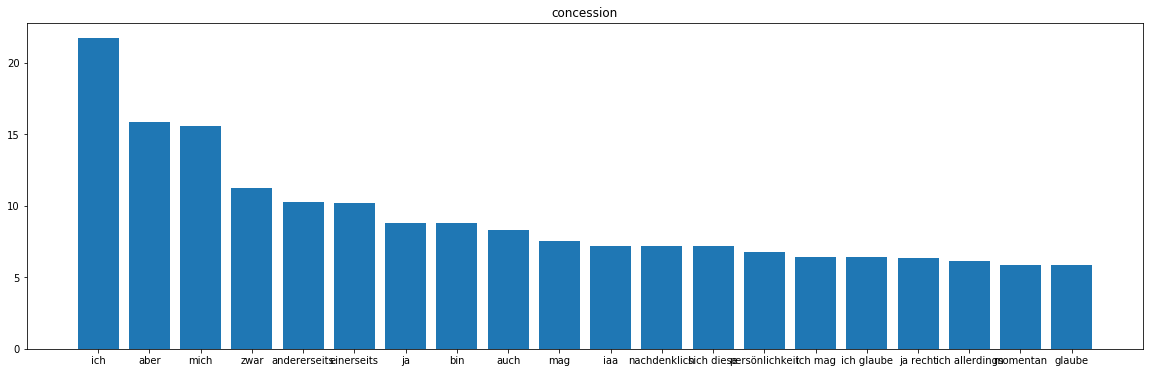

In [6]:
N = 20
for index, cat in id_to_category.items():
    fig = plt.figure(figsize=[20, 6])
    plt.bar(range(N), features_chi2[index][0:N])
    plt.xticks(range(N), feature_names[index][0:N])
    plt.title(cat)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['utterance'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["Da musst du aber noch mal ran, das muss noch besser werden!"])))

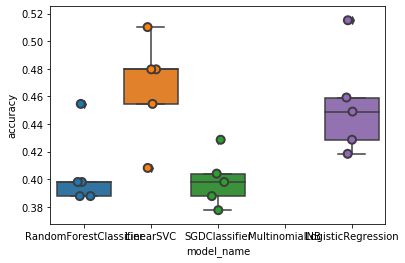

model_name
LinearSVC                 0.466419
LogisticRegression        0.454051
MultinomialNB                  NaN
RandomForestClassifier    0.405195
SGDClassifier             0.399175
Name: accuracy, dtype: float64

In [4]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    SGDClassifier(tol=1e-3, max_iter=1000, loss='modified_huber'),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, df_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()

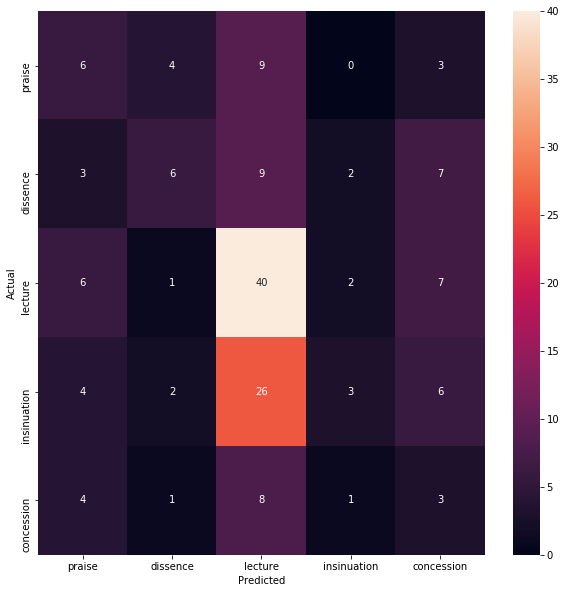

In [4]:
## BUILD CONFUSION MATRIX WITH TRAIN/SPLIT

from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
model = SGDClassifier(tol=1e-3, max_iter=1000, random_state=0, loss='modified_huber')
# model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, df.category_id, range(len(df.category_id)), test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [5]:
## SHOW WRONG SENTENCES WITH TRAIN/SPLIT

from IPython.display import display
import numpy as np

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
        selected_indices = y_test[(y_test == actual) & (y_pred == predicted)]
        print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
        display(df.loc[selected_indices.index][['category', 'utterance']])
        print('')

'insinuation' predicted as 'lecture' : 26 examples.


,category,utterance
325,insinuation,Medien und die wissenschaftlichen Hofschranzen...
445,insinuation,Offenbar verwechseln Sie den Berliner Innensen...
442,insinuation,Sie haben anscheinend keine Ahnung vom Rechtss...
360,insinuation,"Das wird auch die Grünen treffen, die nichts a..."
411,insinuation,"Man kann sich die Frage stellen, was sucht ein..."
247,insinuation,"Wow, es schein massig Verfassungsrechtler hier..."
322,insinuation,Wir werden es erfahren weil die Lügner sich ge...
332,insinuation,Alles ist mal wieder inszeniert um die Aufmerk...
113,insinuation,"Mir scheint es also, dass Sie Pseudolinke mein..."
229,insinuation,"Wenn es um Russland geht, ist keine infame Bes..."


Loading /Users/staude/Projekte/BorisJoens/SmallData/webserver/model_data/TrainingDataTestSet01.tsv
Vectorizing Corpus ...
Removed 0 sentences


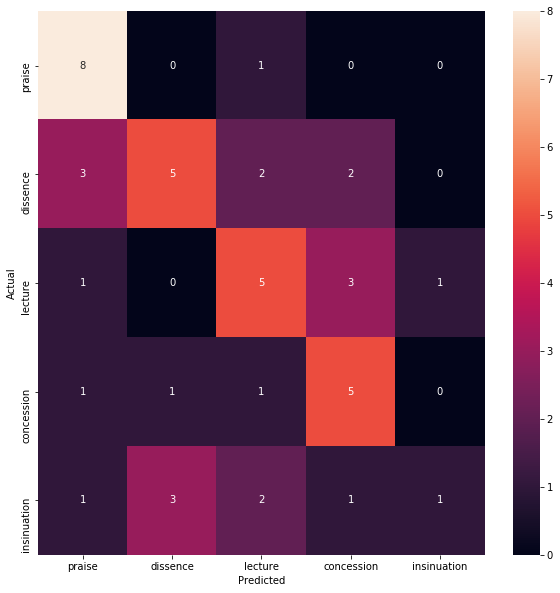

In [8]:
## BUILD CONFUSION MATRIX WITH DEDICATED TEST-SET

from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
model = SGDClassifier(tol=1e-3, max_iter=1000, random_state=0, loss='modified_huber')
# model = MultinomialNB()

df_test = trainer.load_training_files(data_path, ['TestSet'], categories_to_consider)
df_test, features_test = vectorize(df_test, vectorizer_name)

model.fit(features, df.category_id)

y_pred = model.predict(features_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test.category_id, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
## SHOW WRONG SENTENCES WITH DEDICATED TEST SET

from IPython.display import display
import numpy as np

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 1:
        selected_indices = df_test.category_id[(df_test.category_id == actual) & (y_pred == predicted)]
        print("'{}' predicted as '{}' : {} examples:".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
        for i, row in df_test.loc[selected_indices.index].iterrows():
             print(row['utterance'])
#         display(df_test.loc[selected_indices.index][['category', 'utterance']])
        print('')

'dissence' predicted as 'praise' : 3 examples:
Laptopkonzerte find ich kacke
wenn das jetzt die Zukunft von Konzerten werden soll, dann Gute Nacht
puh wieder dieses affektierte Tech Gepose. Und dann auch noch schlecht gemacht

'lecture' predicted as 'praise' : 1 examples:
ihr solltet wirklich mal etwas mehr Abwechslung bringen

'concession' predicted as 'praise' : 1 examples:
als Kunstinstallation mag es ja ganz interessant sein, obwohl Stimmung nicht so richtig aufkommt

'insinuation' predicted as 'praise' : 1 examples:
Wie putzig: alte Knacker machen einen auf modern

'concession' predicted as 'dissence' : 1 examples:
einerseits ganz schön verkopft, andererseits schon nicht so uninteressant

'insinuation' predicted as 'dissence' : 3 examples:
ach ja, da soll mir hier also wieder etwas beibebracht werden
klar, mit staatsknete und zuviel freizeit kommt dann sowas heraus
die meisten hier wissen noch nichtmal was es heisst sowas zu programmieren

'praise' predicted as 'lecture' : 1 examp

In [12]:
df_test

,utterance,category,category_id
0,"total geniale Sache, selten sowas tolles geseh...",praise,0
1,"boah wie abgefahren, dass das auch noch so sch...",praise,0
2,"Richtig super, gerade auch die Musik. Das groo...",praise,0
3,"absolut überzeugende Arbeit, Leute. Ich will a...",praise,0
4,"wo spielt ihr denn das nächste Mal, muss ich u...",praise,0
5,Das fetzt ja total. Bin beeindruckt und glücklich,praise,0
6,"Extrem faszinierend, wie man Sprach einsetzen ...",praise,0
7,Danke für diesen tollen und inspirierenden Abend,praise,0
8,"Ziemlich coole Art, Musik und Publikum zusamme...",praise,0
9,"ich hätte nicht gedacht, dass das so gut ist. ...",dissence,1


In [46]:
df_test

,utterance,category,category_id
0,"total geniale Sache, selten sowas tolles geseh...",praise,0
1,"boah wie abgefahren, dass das auch noch so sch...",praise,0
2,"Richtig super, gerade auch die Musik. Das groo...",praise,0
3,"absolut überzeugende Arbeit, Leute. Ich will a...",praise,0
4,"wo spielt ihr denn das nächste Mal, muss ich u...",praise,0
5,Das fetzt ja total. Bin beeindruckt und glücklich,praise,0
6,"Extrem faszinierend, wie man Sprach einsetzen ...",praise,0
7,Danke für diesen tollen und inspirierenden Abend,praise,0
8,"Ziemlich coole Art, Musik und Publikum zusamme...",praise,0
9,"ich hätte nicht gedacht, dass das so gut ist. ...",dissence,1


In [41]:
y_pred[9]

0

In [9]:
clean_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,Merkel war und ist hier eine getriebene,Das ist doch albern.,Dass ich nicht lache,Sie haben schlicht gar nichts begriffen.,Stellen Sie sich nicht dumm,Paragraphen-Nachhilfe für Nazis,DON'T FEED THE TROLL!!,"Dann werden Sie sicherlich verstehen, warum vo...",Sie sollten sich mein Posting noch einmal in R...,"Gott sei dank, Dankeschön!",...,Watzinger war wahrscheinlich etwas zu häufig a...,Und nun sollen wir alle ihn schön vor dem Risi...,"Sie sollten doch wissen, von wem sich Streeck ...",Oh man...hier haben Sie aber ins Wespennest ge...,"Ja, es geht um Menschen. Allerdings nicht nur ...",Die werden in der Corona-Zeit leider fast komp...,"Es gibt die Angst-Paniker, die ihr eigenes Ris...","Nein, so funktioniert Eigenverantwortung nicht.","Es geht um unser aller Leben, es geht um Exist...",Das nennt man Lebensrisiko.
1,0,1,2,1,1,0,0,1,1,3,...,0,0,1,1,1,1,0,2,1,1


In [84]:
len(df)

3638

In [ ]:
## Check doc2vec
# taken from https://medium.com/towards-artificial-intelligence/text-classification-by-xgboost-others-a-case-study-using-bbc-news-articles-5d88e94a9f8
import pandas as pd

file = '../webserver/model_data/TrainingData_ml.xlsx'
df = pd.read_excel(file).rename(columns={'Effekt': 'category'})
col = ['utterance', 'category']
df = df[col]

from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.strip_short, 
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline



def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

    
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + clean_text(item['utterance'])
    
plot_word_cloud(texts)

In [ ]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['utterance'])
    
    plot_word_cloud(texts)

In [ ]:
plot_word_cloud_for_category(df,'praise')